# Tạo chatbot đơn giản
Hai hướng tiếp cận chính:

- Retrieval based: Hướng tiếp cận này sẽ truy vấn câu trả lời từ một tập các câu trả lời được định nghĩa trước. Không yêu cầu hiểu câu ý nghĩa của câu.

- Task oriented: Yêu cầu hiểu ý nghĩa của câu (ý định và các thực thể trong câu) để xử lý riêng cho từng trường hợp.

## Cài đặt các thư viện cần thiết

In [1]:
!pip install nltk
!pip install scikit-learn
!pip install wit

## Import các thư viện cần thiết

In [2]:
import nltk
import numpy as np
import io # read input write output
import random # generate random numbers
import string # to process standard python strings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from wit import Wit
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Retrieval based

### Đọc văn bản

In [3]:
with open('./corpus_light.txt', 'r', encoding='utf-8') as file:
  corpus = file.read()
sentences_raw = corpus.split('\n')

In [4]:
sentences_raw[:10]

['The Landmark 81 là một toà nhà chọc trời trong tổ hợp dự án Vinhomes Tân Cảng , một dự án có tổng mức đầu tư 40.000 tỷ đồng , do Công ty Cổ phần Đầu tư xây dựng Tân Liên Phát thuộc Vingroup làm chủ đầu tư . Toà tháp cao 81 tầng , hiện tại là toà nhà cao nhất Việt Nam và là toà nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 .',
 'Toà tháp cao 81 tầng , hiện tại là toà nhà cao nhất Việt Nam và là toà nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 . Dự án được xây dựng ở Tân Cảng , quận Bình Thạnh , ven sông Sài Gòn . Dự án được khởi công ngày 26/07/2014 .',
 'Đôi chân ngắn nhưng mạnh mẽ giúp Messi dễ dàng tăng tốc và sải chân nhanh giúp anh kiểm soát bóng tốt khi rê dắt ở tốc độ cao . Cựu huấn luyện viên Barcelona , Pep Guardiola , từng nhận xét rằng : \\" Messi là cầu thủ duy nhất chạy với bóng còn nhanh hơn là chạy không bóng . \\" Giống Maradona , Messi là một cầu thủ thuận chân trái .',
 'Cựu huấn luyện viên Barcelona , Pep Guardiola , từng nhận xét rằng : \\" Messi là cầu thủ duy nhất c

### Biểu diễn văn bản dưới dạng vector
Phương pháp đơn giản nhất là sử dụng Bag of Word (BoW) (Túi đựng Từ). BoW sẽ biểu diễn một văn bản dưới dạng một tập V các từ (V là toàn bộ từ trong từ điển) và bỏ qua các thông tin về trật tự của từ và ngữ pháp. Lấy ví dụ tập dữ liệu gồm 2 câu: 

- Bình thích xem phim. Linh cũng thích xem phim
- Bình cũng thích xem đá bóng

Dựa trên tập dữ liệu này, ta có thể xây dựng được tập từ điển gồm có các từ sau (bỏ qua việc viết hoa): {bình, linh, thích, xem, phim, cũng, đá, bóng}

Hai câu trong tập dữ liệu sẽ được biểu diễn dưới dạng vector theo BoW như sau:

- [1, 1, 2, 2, 2, 1, 0, 0]
- [1, 0, 1, 1, 0, 1, 1, 1]

### Chuẩn hoá lại văn bản

- Chuyển sang dạng viết thường
- Phân tách các ký tự đặc biệt

In [5]:
def norm_sentences(sen):
  sen = sen.lower()
  sen = ' '.join(nltk.word_tokenize(sen))
  return sen

sentences = [norm_sentences(item) for item in sentences_raw]
corpus = ' '.join(sentences)

In [6]:
sentences[:10]

['the landmark 81 là một toà nhà chọc trời trong tổ hợp dự án vinhomes tân cảng , một dự án có tổng mức đầu tư 40.000 tỷ đồng , do công ty cổ phần đầu tư xây dựng tân liên phát thuộc vingroup làm chủ đầu tư . toà tháp cao 81 tầng , hiện tại là toà nhà cao nhất việt nam và là toà nhà cao nhất đông nam á từ tháng 3 năm 2018 .',
 'toà tháp cao 81 tầng , hiện tại là toà nhà cao nhất việt nam và là toà nhà cao nhất đông nam á từ tháng 3 năm 2018 . dự án được xây dựng ở tân cảng , quận bình thạnh , ven sông sài gòn . dự án được khởi công ngày 26/07/2014 .',
 "đôi chân ngắn nhưng mạnh mẽ giúp messi dễ dàng tăng tốc và sải chân nhanh giúp anh kiểm soát bóng tốt khi rê dắt ở tốc độ cao . cựu huấn luyện viên barcelona , pep guardiola , từng nhận xét rằng : \\ '' messi là cầu thủ duy nhất chạy với bóng còn nhanh hơn là chạy không bóng . \\ '' giống maradona , messi là một cầu thủ thuận chân trái .",
 "cựu huấn luyện viên barcelona , pep guardiola , từng nhận xét rằng : \\ '' messi là cầu thủ duy 

### Tạo từ điển
Từ điển sẽ cho ta biết được danh sách các từ và mã đại diện của các từ đó

In [7]:
word_list = list(set(corpus.split()))
dictionary = {word: index + 1 for index, word in enumerate(word_list)}

In [8]:
len(dictionary)

5129

In [9]:
dictionary.get('học', 0)

10

### Tạo hàm biểu diễn câu dưới dạng vector sử dụng BoW

In [10]:
def representation_sentence(sen):
  sen = norm_sentences(sen)
  sen_vec = [0] * (len(dictionary) + 1)
  for word in sen.split():
    sen_vec[dictionary.get(word, 0)] += 1
  return sen_vec

In [11]:
sentences_vec = [representation_sentence(item) for item in sentences] 

### Tính độ tương đồng giữa hai vecctor

Phương pháp: Cosine similarity. Đo khoảng cách giữa hai vector. Càng gần nhau giá trị cosine càng to

In [12]:
sen_1 = "Bình thích xem phim"
sen_2 = "Linh cũng thích xem phim"
sen_3 = "Bình học lập trình"
print("Khoảng cách sen_1, sen_2:", cosine_similarity([representation_sentence(sen_1)], [representation_sentence(sen_2)]))
print("Khoảng cách sen_1, sen_3:", cosine_similarity([representation_sentence(sen_1)], [representation_sentence(sen_3)]))
print("Khoảng cách sen_2, sen_3:", cosine_similarity([representation_sentence(sen_2)], [representation_sentence(sen_3)]))

Khoảng cách sen_1, sen_2: [[0.67082039]]
Khoảng cách sen_1, sen_3: [[0.25]]
Khoảng cách sen_2, sen_3: [[0.]]


#### Tạo hàm tìm câu có độ tương đồng cao nhất

In [13]:
def find_retrieval_response(input_sen):
  similarity = cosine_similarity(sentences_vec, [representation_sentence(input_sen)]).squeeze()
  max_index = similarity.argmax()
  # print(similarity[max_index])
  if similarity[max_index] < 0.3:
    return None
  else:
    return sentences_raw[max_index]

In [14]:
find_retrieval_response("các dân tộc việt nam")

'Các dân tộc tại Việt Nam hay người Việt Nam là một danh từ chung để chỉ các dân tộc sống trên lãnh thổ Việt Nam .'

## Task oriented

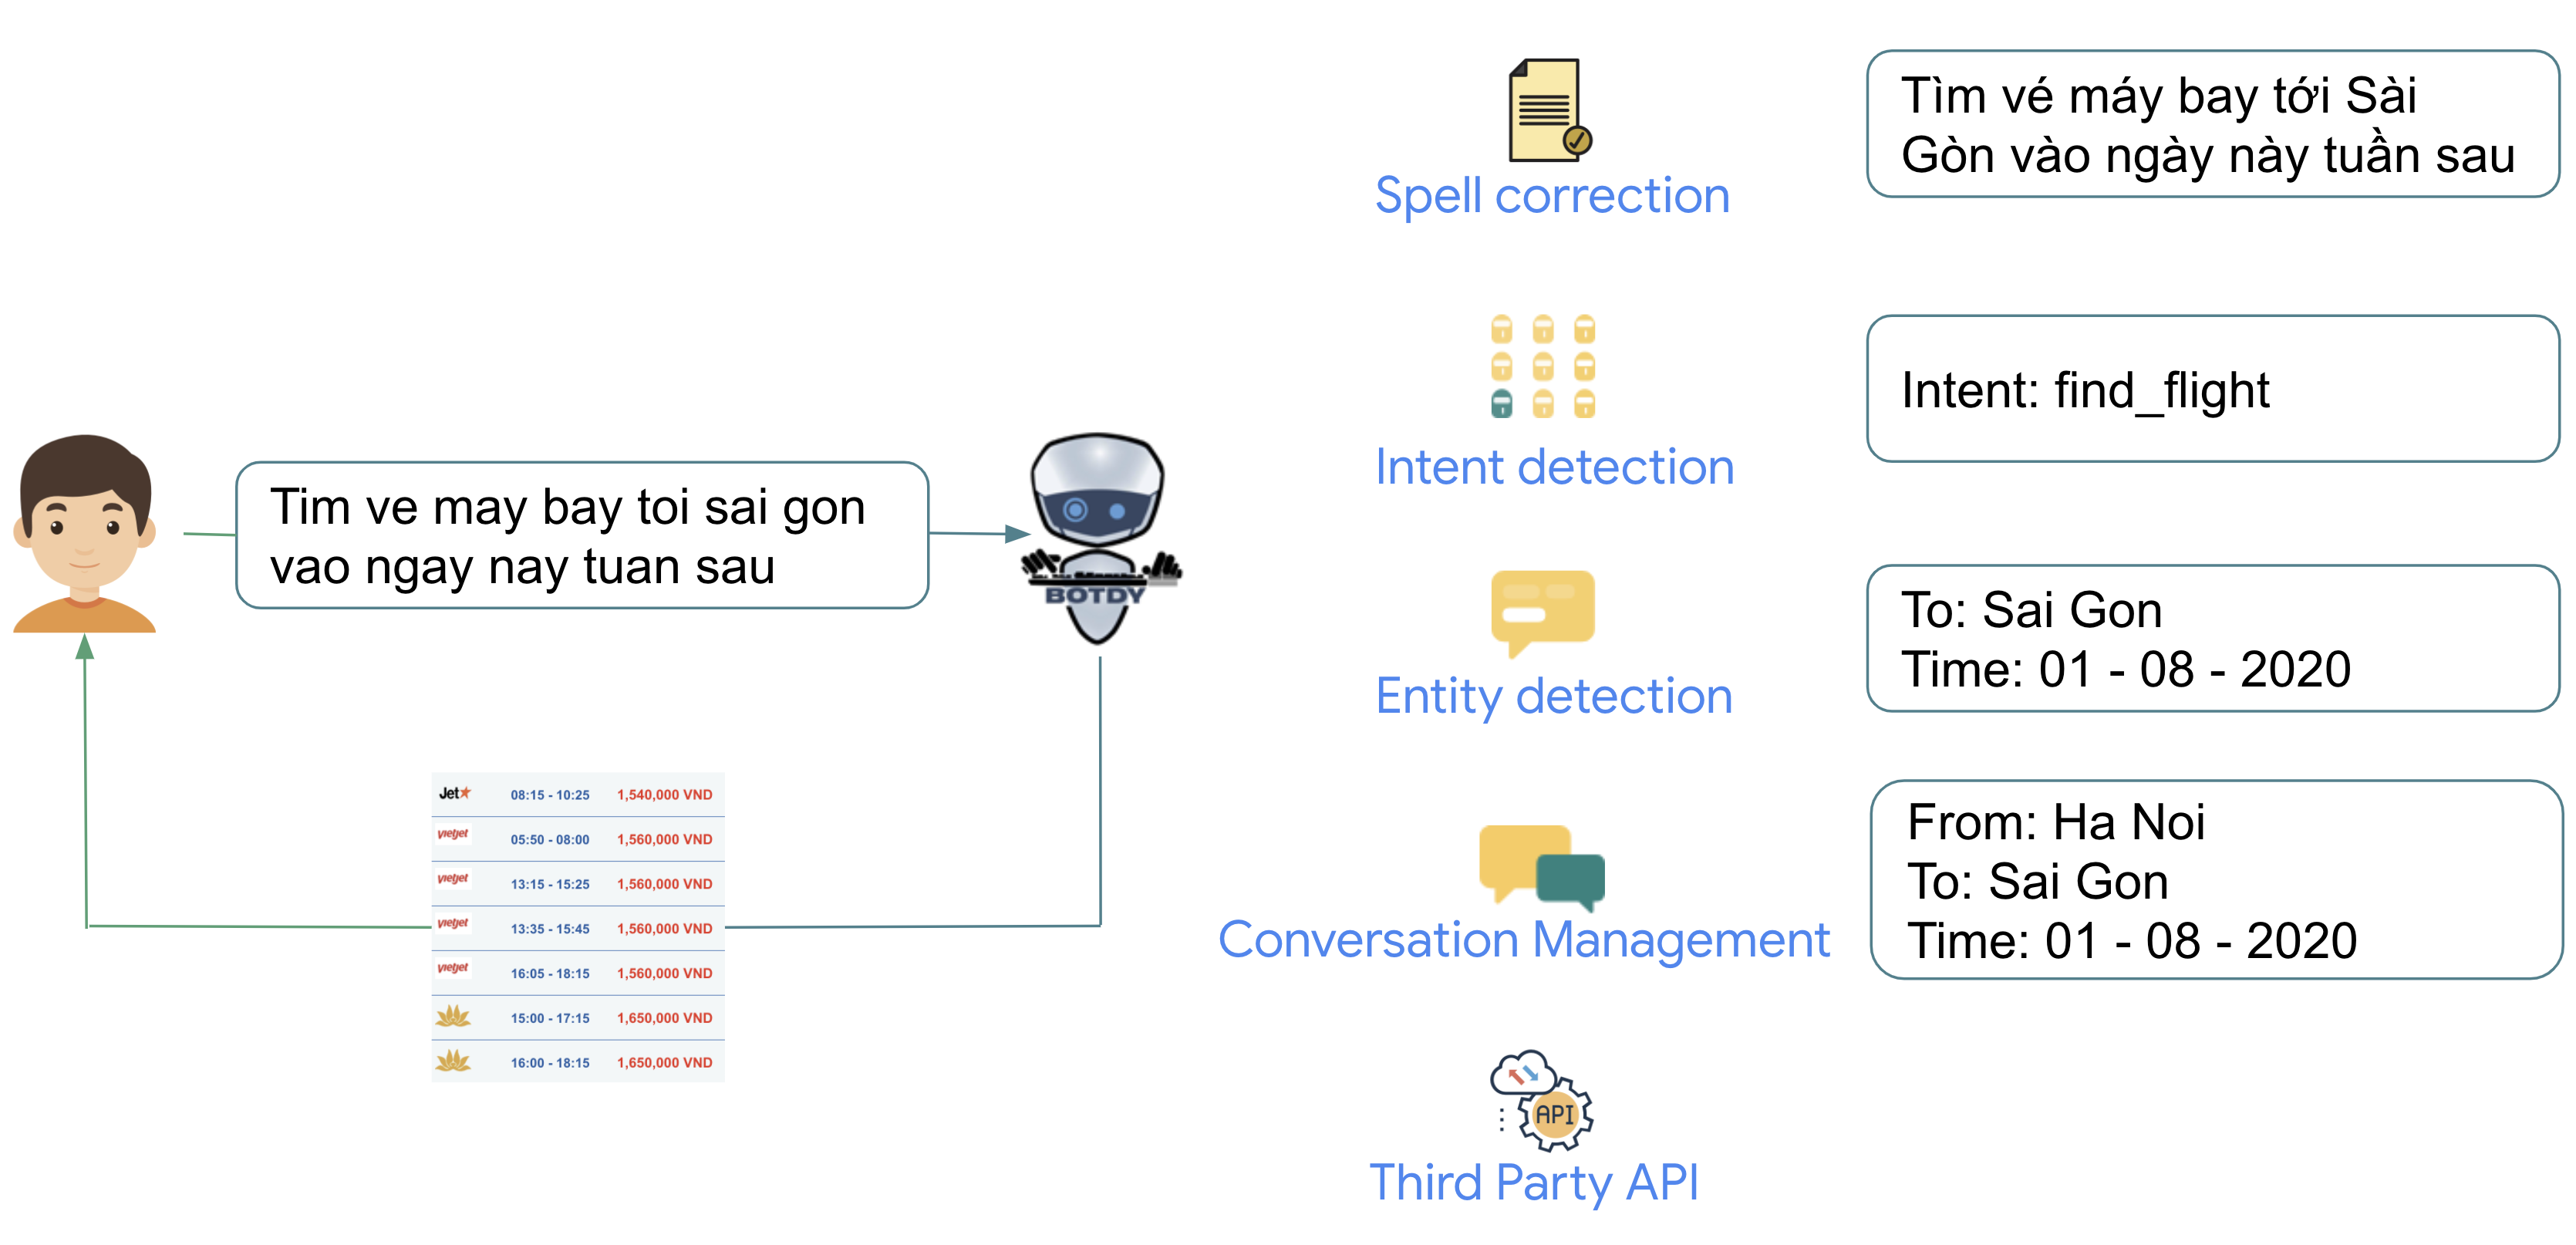

In [15]:
client = Wit('B6QGNQA3EFUYMP4QGHPNL3UYNTE7CMQH')

### Truy vấn intent của câu nói

In [16]:
def get_intent(input_sen):
  nlu_result = client.message(input_sen)
  if nlu_result.get('intents', None):
    return nlu_result.get('intents', None)[0]['name']
  else:
    return None

### Định nghĩa câu trả lời

In [17]:
def find_oriented_response(input_sen):
  intent_type = get_intent(input_sen)
  if intent_type == 'thank':
    return random.choice([':)', 'đây là nhiệm vụ của mình mà', 'ok bạn'])
  elif intent_type == 'greeting':
    return random.choice(['hello bạn', 'chào bạn', 'hi', 'hello'])
  elif intent_type == 'ask_name':
    return random.choice(['SheBeauty', 'Mình tên là SheBeauty', 'SheBeauty ạ'])
  elif intent_type == 'goodbye':
    return random.choice(['Hẹn gặp bạn lần sau nhé', 'Bye', "Nói chuyện sau nhé"])
  else:
    return None

In [18]:
find_oriented_response('xin chào')

'hello bạn'

In [19]:
find_oriented_response('cảm ơn')

':)'

In [20]:
find_oriented_response('tạm biệt')

'Bye'

In [21]:
find_oriented_response('bạn tên gì?')

'Mình tên là SheBeauty'

## Ghép nối hệ thống các module để tạo chatbot hoàn chỉnh

In [26]:
while True:
  user_input = input("You: ")
  if user_input == "quit":
    print("Bot: {}".format("-_- bye"))
    break
  # Tìm câu trả lời của task oriented
  oriented_response = find_oriented_response(user_input)
  if oriented_response:
    print("Bot: {}".format(oriented_response))
  else:
    # Tìm câu trả lời theo hướng retrieval
    retrieval_response = find_retrieval_response(user_input)
    if retrieval_response:
      print("Bot: {}".format(retrieval_response))
    else:
      print("Bot: {}".format("Xin lỗi bạn mình không có câu trả lời!"))


You: Xin chào
Bot: hello bạn
You: Bạn tên gì thế?
Bot: Mình tên là SheBeauty
You: Sao Hoả là hành tinh thứ mấy trong Thái Dương Hệ ?
Bot: Sao Hoả còn gọi là : Hoả Tinh , ( Tiếng Anh : Mars ) là hành tinh thứ tư tính từ Mặt Trời trong Thái Dương Hệ . Đôi khi hành tinh này còn được gọi tên là Hoả Tinh . Nó thường được gọi với tên khác là \" Hành tinh Đỏ \" , do sắt ôxít có mặt rất nhiều trên bề mặt hành tinh làm cho bề mặt nó hiện lên với màu đỏ đặc trưng .
You: Oh! Cảm ơn bạn nhé!
Bot: :)
You: tạm biệt bạn
Bot: Nói chuyện sau nhé
You: quit
Bot: -_- bye
